<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

**ТЗ**

Инструкция по выполнению проекта

1. Подготовьте данные

- Откройте файлы и изучите их.
Путь к файлам:

/datasets/gold_industry_train.csv. 

/datasets/gold_industry_test.csv.

/datasets/gold_industry_full.csv. 

- Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.
- Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
- Проведите предобработку данных.

2. Проанализируйте данные

- Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате. Какие особенности имеют распределения? Опишите выводы.
- Сравните распределения размеров гранул исходного сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.
- Исследуйте суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

3. Постройте модель

- Напишите функцию для вычисления итоговой sMAPE.
- Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

Вам пригодятся формулы метрик качества:
формула sMAPE

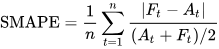

**Process**

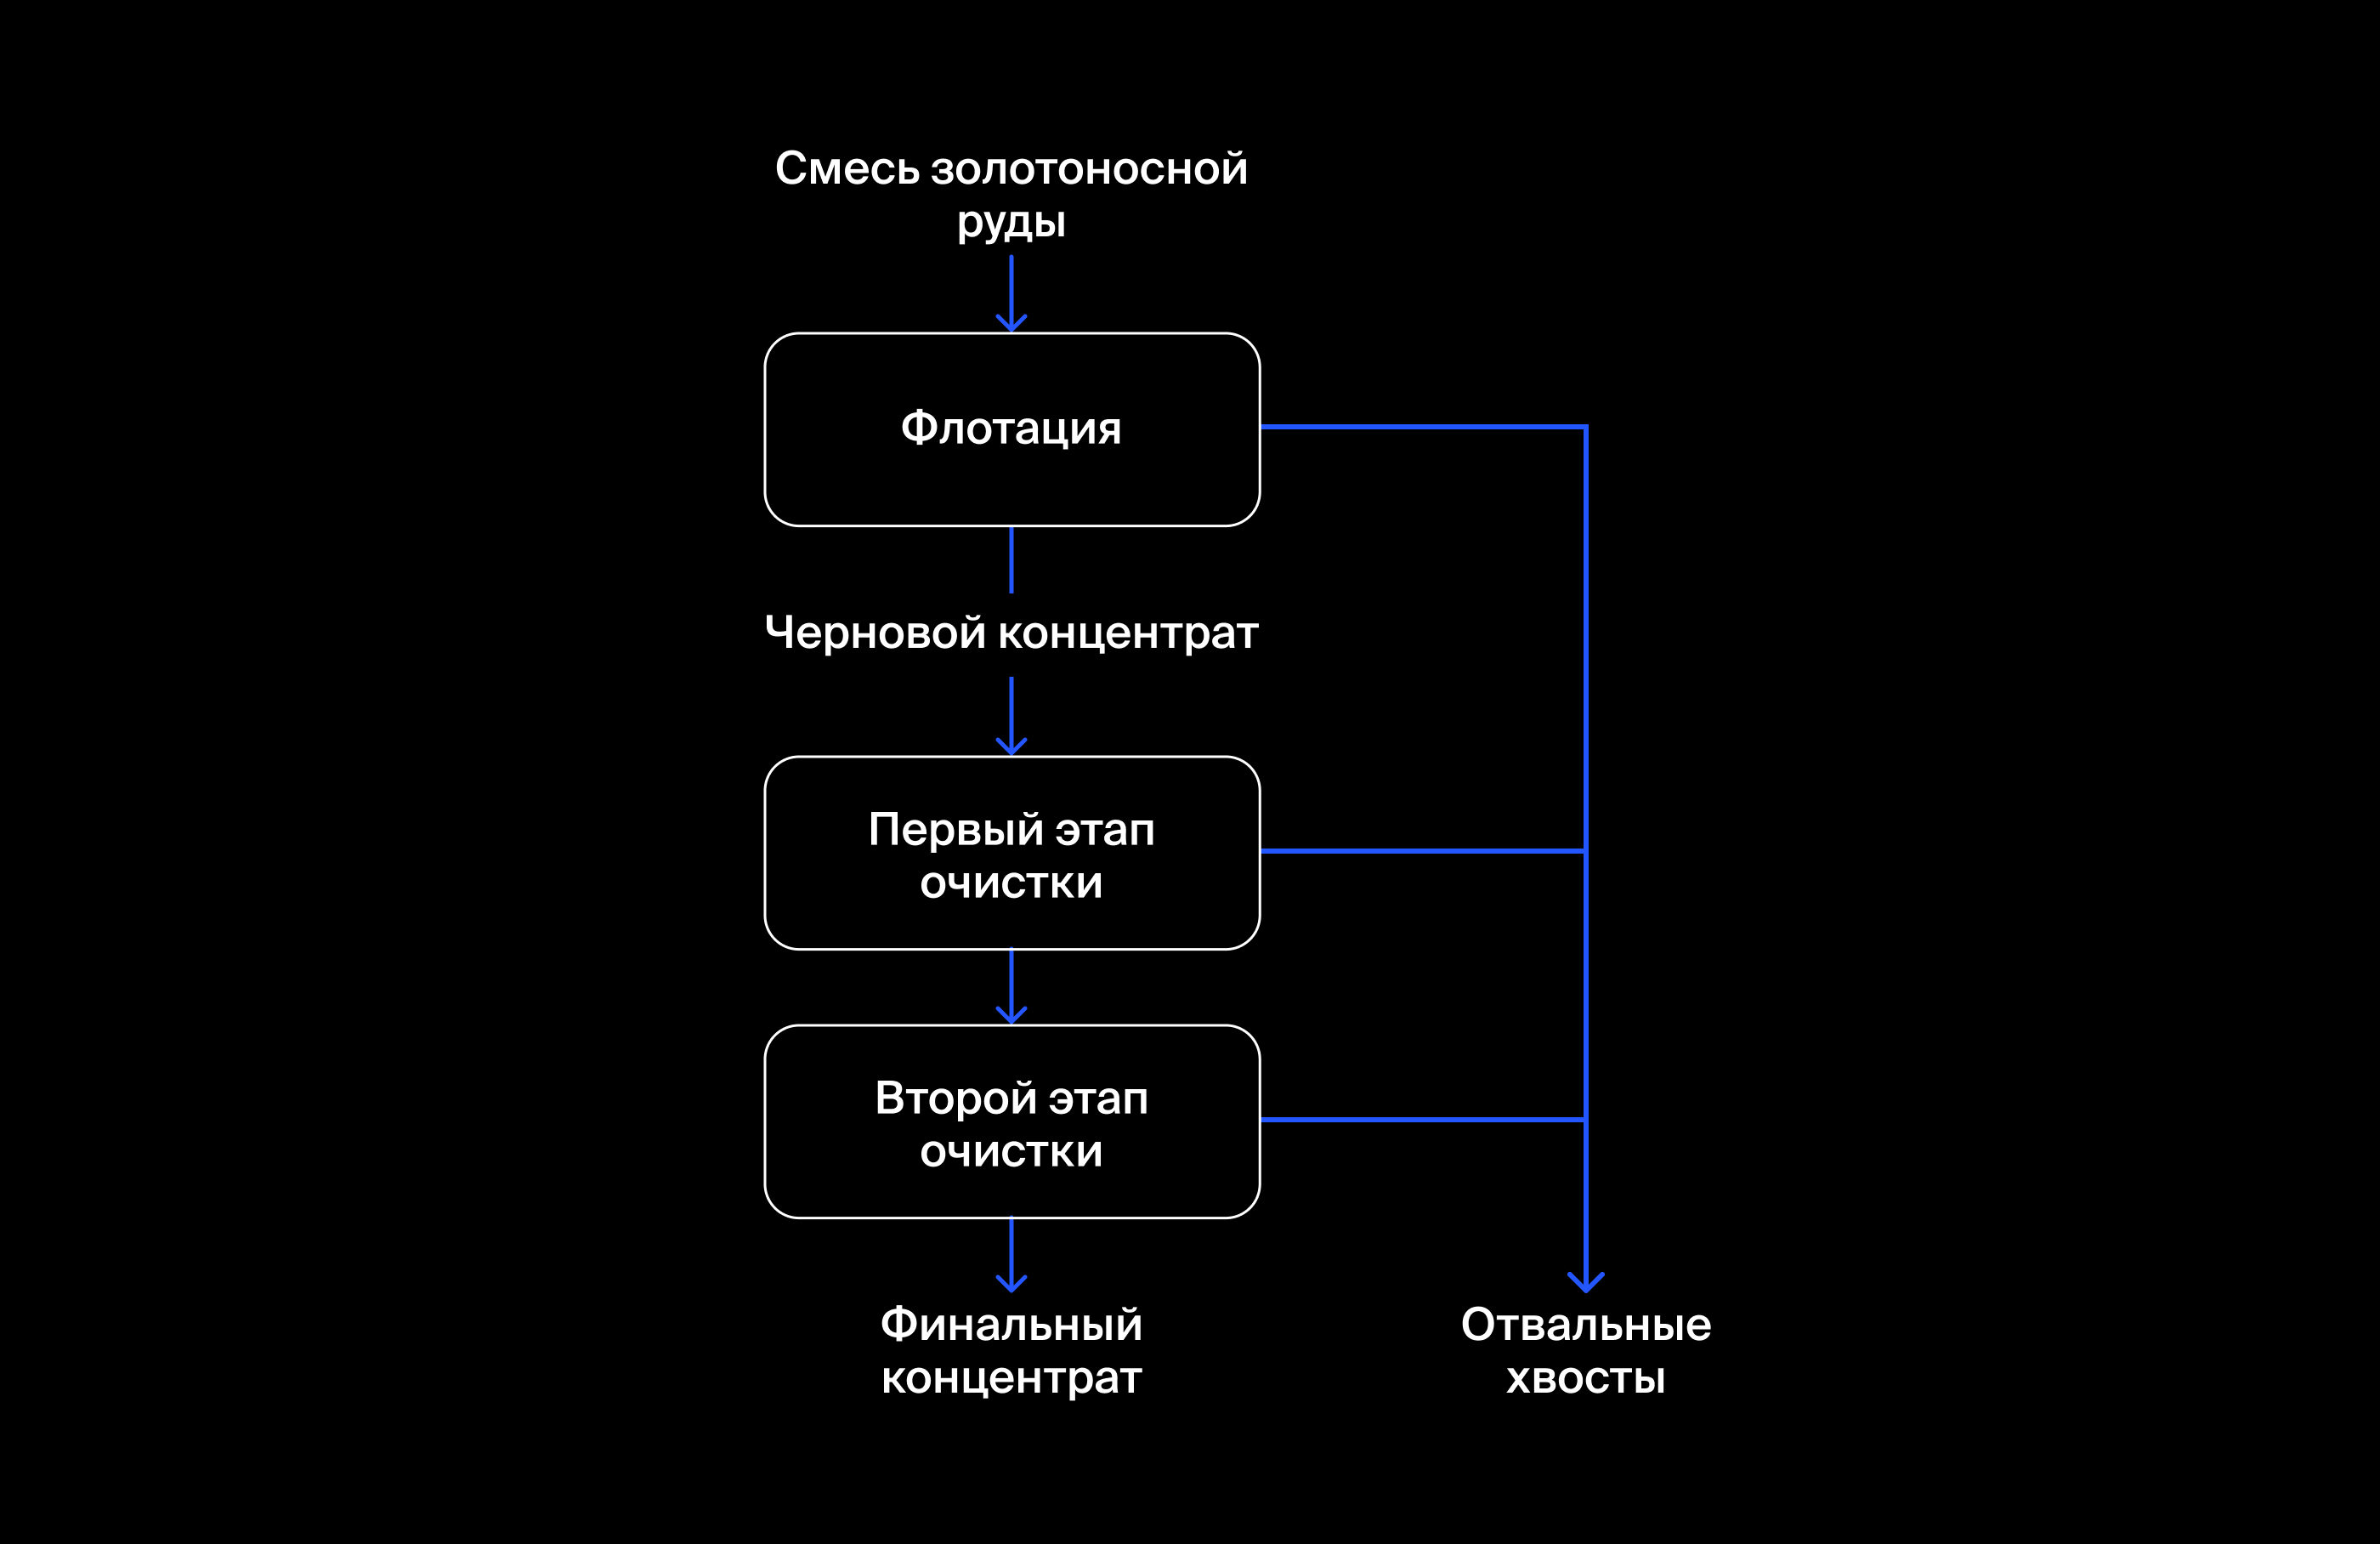

**Recovery**

 **$Recovery = \large\frac{C\cdot(F-T)}{F\cdot(C-T)}\small\cdot100$%**

где:

C — доля золота в концентрате после флотации/очистки;

F — доля золота в сырье/концентрате до флотации/очистки;

T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

**Итоговое sMAPE = 0.25 * sMAPE(rougher) * 0.75 sMAPE(final)**

## Подготовка данных

In [117]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

In [2]:
df_train = pd.read_csv('/datasets/gold_industry_train.csv', 
                       encoding='UTF-8', 
                       parse_dates=['date'], 
                       index_col='date')
df_train.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,-400.074028,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,-400.200179,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,-399.752729,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [3]:
df_test = pd.read_csv('/datasets/gold_industry_test.csv', 
                      encoding='UTF-8', 
                      parse_dates=['date'], 
                      index_col='date')
df_test.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,-299.862743,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,-299.907308,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,-300.124116,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,-299.778385,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,-300.283401,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805


In [4]:
df_full = pd.read_csv('/datasets/gold_industry_full.csv', 
                      encoding='UTF-8', 
                      parse_dates=['date'], 
                      index_col='date')
df_full.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,-400.074028,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,-400.200179,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,-399.752729,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [5]:
print(f'Train shape: {df_train.shape}\n'
      f'Test shape: {df_test.shape}\n'
      f'Full shape: {df_full.shape}')

Train shape: (14579, 86)
Test shape: (4860, 52)
Full shape: (19439, 86)


В тестовой выборке пропущены поля


In [6]:
def statistical_info(df):
    return df.info(), df.isna().sum()

In [7]:
statistical_info(df_train)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14579 entries, 2016-01-15 00:00:00 to 2017-12-09 13:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               14579 non-null  float64
 1   rougher.input.feed_ag                               14579 non-null  float64
 2   rougher.input.feed_pb                               14507 non-null  float64
 3   rougher.input.feed_sol                              14502 non-null  float64
 4   rougher.input.feed_rate                             14572 non-null  float64
 5   rougher.input.feed_size                             14478 non-null  float64
 6   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 7   rougher.input.floatbank10_xanthate                  14572 non-null  float64
 8   rougher.state.floatbank10_a_air          

(None,
 rougher.input.feed_au       0
 rougher.input.feed_ag       0
 rougher.input.feed_pb      72
 rougher.input.feed_sol     77
 rougher.input.feed_rate     7
                            ..
 final.output.recovery       0
 final.output.tail_au        0
 final.output.tail_ag        1
 final.output.tail_pb       75
 final.output.tail_sol       5
 Length: 86, dtype: int64)

In [8]:
statistical_info(df_test)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4860 entries, 2017-12-09 14:59:59 to 2018-08-18 10:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       4860 non-null   float64
 1   rougher.input.feed_ag                       4860 non-null   float64
 2   rougher.input.feed_pb                       4832 non-null   float64
 3   rougher.input.feed_sol                      4838 non-null   float64
 4   rougher.input.feed_rate                     4856 non-null   float64
 5   rougher.input.feed_size                     4816 non-null   float64
 6   rougher.input.floatbank10_sulfate           4857 non-null   float64
 7   rougher.input.floatbank10_xanthate          4859 non-null   float64
 8   rougher.state.floatbank10_a_air             4859 non-null   float64
 9   rougher.state.floatbank10_a_level           4859 

(None,
 rougher.input.feed_au                           0
 rougher.input.feed_ag                           0
 rougher.input.feed_pb                          28
 rougher.input.feed_sol                         22
 rougher.input.feed_rate                         4
 rougher.input.feed_size                        44
 rougher.input.floatbank10_sulfate               3
 rougher.input.floatbank10_xanthate              1
 rougher.state.floatbank10_a_air                 1
 rougher.state.floatbank10_a_level               1
 rougher.state.floatbank10_b_air                 1
 rougher.state.floatbank10_b_level               1
 rougher.state.floatbank10_c_air                 1
 rougher.state.floatbank10_c_level               1
 rougher.state.floatbank10_d_air                 0
 rougher.state.floatbank10_d_level               0
 rougher.state.floatbank10_e_air                 7
 rougher.state.floatbank10_e_level               0
 rougher.state.floatbank10_f_air                 0
 rougher.state.floatbank

In [9]:
statistical_info(df_full)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               19439 non-null  float64
 1   rougher.input.feed_ag                               19439 non-null  float64
 2   rougher.input.feed_pb                               19339 non-null  float64
 3   rougher.input.feed_sol                              19340 non-null  float64
 4   rougher.input.feed_rate                             19428 non-null  float64
 5   rougher.input.feed_size                             19294 non-null  float64
 6   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 7   rougher.input.floatbank10_xanthate                  19431 non-null  float64
 8   rougher.state.floatbank10_a_air          

(None,
 rougher.input.feed_au        0
 rougher.input.feed_ag        0
 rougher.input.feed_pb      100
 rougher.input.feed_sol      99
 rougher.input.feed_rate     11
                           ... 
 final.output.recovery        0
 final.output.tail_au         0
 final.output.tail_ag         1
 final.output.tail_pb       101
 final.output.tail_sol        6
 Length: 86, dtype: int64)

Посмотрим, каких полей не хватает в тестовой выборке

In [10]:
cols_to_keep = set(df_train.columns) - set(df_test.columns)
df_filtered = df_full[cols_to_keep]
statistical_info(df_filtered)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.output.tail_au                              19439 non-null  float64
 1   primary_cleaner.output.concentrate_pb               19323 non-null  float64
 2   rougher.output.recovery                             19439 non-null  float64
 3   rougher.output.concentrate_sol                      19416 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.concentrate_au                         19439 non-null  float64
 6   rougher.calculation.au_pb_ratio                     19439 non-null  float64
 7   rougher.output.concentrate_pb                       19439 non-null  float64
 8   primary_cleaner.output.concentrate_ag    

(None,
 rougher.output.tail_au                                   0
 primary_cleaner.output.concentrate_pb                  116
 rougher.output.recovery                                  0
 rougher.output.concentrate_sol                          23
 final.output.recovery                                    0
 final.output.concentrate_au                              0
 rougher.calculation.au_pb_ratio                          0
 rougher.output.concentrate_pb                            0
 primary_cleaner.output.concentrate_ag                    0
 final.output.tail_sol                                    6
 rougher.calculation.sulfate_to_au_concentrate            2
 primary_cleaner.output.concentrate_au                    0
 rougher.output.concentrate_ag                            0
 primary_cleaner.output.tail_ag                           4
 secondary_cleaner.output.tail_ag                         2
 rougher.output.tail_sol                                  0
 rougher.output.concentrate_au   

Не хватает 34 полей, среди которых, потенциально, могут быть целевые переменные

**Вывод о возможных причинах расхождения признаков**

Мы можем сделать несколько предположений, касаемо отсутствия данных

1) Проблемы в сборе данных:

- Онлайн метрики: В случае онлайн метрик, возможны проблемы с подключением или передачей данных из-за интернет-соединения, сбоев в сенсорах или оборудовании, недоступности серверов и т.д.
- Офлайн метрики: При сборе данных для офлайн анализа могут возникнуть проблемы с записью, хранением или извлечением данных, например, из-за ошибок в процессе записи или сбоях в хранилищах данных

2) Недостаточное время для сбора данных:

- Онлайн и офлайн метрики: Если процесс анализа начался раньше, чем были собраны данные о промежуточных признаках и целевых переменных в тестовой выборке, то это может привести к отсутствию этих данных

3)  Технические ограничения:

- Онлайн и офлайн метрики: Возможно, некоторые промежуточные признаки или целевые переменные из-за технических ограничений или ошибок были исключены из тестовой выборки

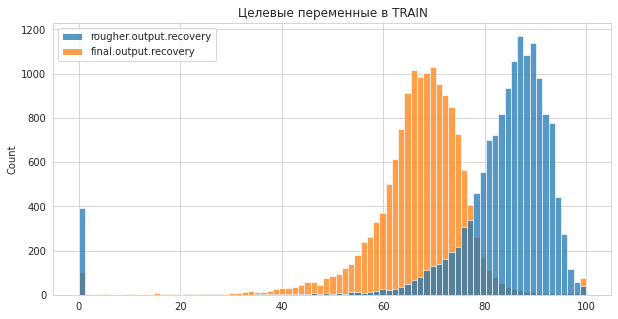

In [11]:
try:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_train[['rougher.output.recovery', 'final.output.recovery']])
    plt.title('Целевые переменные в TRAIN')
    plt.show()
except:
    print('Целевые переменные отсутствуют в данных')

In [12]:
try:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_test[['rougher.output.recovery', 'final.output.recovery']])
    plt.title('Целевые переменные в TEST')
    plt.show()
except:
    print('Целевые переменные отсутствуют в данных')

Целевые переменные отсутствуют в данных


<Figure size 720x360 with 0 Axes>

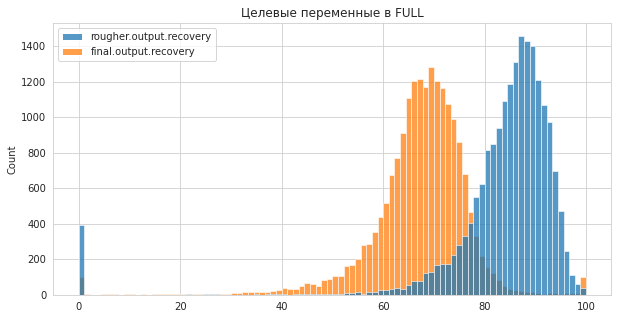

In [13]:
try:
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_full[['rougher.output.recovery', 'final.output.recovery']])
    plt.title('Целевые переменные в FULL')
    plt.show()
except:
    print('Целевые переменные отсутствуют в данных')

**Вывод**

Действительно, в тестовой выборке отсутствуют целевые переменные

In [14]:
df_full[['rougher.output.recovery', 'final.output.recovery']].describe().T

,count,mean,std,min,25%,50%,75%,max
rougher.output.recovery,19439.0,83.328587,14.148086,0.0,81.037957,86.188892,90.010670,100.0
final.output.recovery,19439.0,67.050208,10.125840,0.0,63.299712,68.172738,72.686642,100.0


In [15]:
df_full[['rougher.output.recovery', 'final.output.recovery']].isna().sum()

rougher.output.recovery    0
final.output.recovery      0
dtype: int64

**Вывод по целевым признакам**

- Статистические значение в final.output.recovery меньше, чем в rougher.output.recovery в кварнтилях и среднем
- Все значения распределены в диапазоне 0-100%
- Пропуски в целевых признаках отсутствуют

**Первичный вывод по данным**

- Во всех данные есть пропуски
- В тестовой выборке отсутствует 34 поля, включая целевые переменыне
- Количетсво полей в полной выборке и тренировочной совпадают

**Проверяем рассчёты эффективности обогащения**

Формула:

 $Recovery = \large\frac{C\cdot(F-T)}{F\cdot(C-T)}\small\cdot100$%

In [16]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

rougher_output_recovery_chek = C * (F - T) / (F * (C - T)) * 100

In [17]:
MAE_verification = mean_absolute_error(rougher_output_recovery_chek, 
                                       df_train['rougher.output.recovery']).round(5)
MAE_verification

0.0

**Вывод**

Значение MAE мало, следовательно, мы можем предположить, что эффективность обогащения в rougher.output.recovery рассчитана верно

**Анализ полей, которые отсутствуют в тестовой выборке**

Когда мы смотрели размеры выборок, мы заметили, что в тестовой выборке нет некоторых полей и получили их список, когда анализировали целевые признаки. Сейчас мы проанализируем поля, недоступные тестовой выборке

In [18]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.output.tail_au                              19439 non-null  float64
 1   primary_cleaner.output.concentrate_pb               19323 non-null  float64
 2   rougher.output.recovery                             19439 non-null  float64
 3   rougher.output.concentrate_sol                      19416 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.concentrate_au                         19439 non-null  float64
 6   rougher.calculation.au_pb_ratio                     19439 non-null  float64
 7   rougher.output.concentrate_pb                       19439 non-null  float64
 8   primary_cleaner.output.concentrate_ag    

Помимо целевых признаков, отсутствует множество других. Представим, что мы уточнили момент пропуска данных у заказчика (у наставника/преподавателя)

Признаки:

- final.output.concentrate - финальный концентрат
- final.output.recovery - эффективность обогащения финального концентрата
- final.output.tail - финальные отвальные хвосты
- primary_cleaner.output.concentrate - концентрат после первичной очистки
- primary_cleaner.output.tail - отвальные хвосты после первичной очистки
- rougher.calculation - расчётные характеристики на этапе флотации (обогащения)
- rougher.output.concentrate - черновой концентрат
- rougher.output.recovery - эффективность обогащения чернового концентрата
- rougher.output.tail - отвальные хвосты после обогащения
- secondary_cleaner.output.tail - отвальные хвосты после второго этапа очистки

Большинство признаков с типом output - параметры продукта, несколько признаков с типом calculation - расчётные характеристики.

**Предобработка данных**

In [19]:
def fill_missing_values(df):
    return df.fillna(method='ffill')
# method='ffill' позволяет заполнить значениями, ориентируясь на корреляцию со временем

In [20]:
df_train = fill_missing_values(df_train)

train_with_missing = df_train[df_train.isna().sum(axis=1) > 0]

if train_with_missing.empty:
    print('Пропусков нет')
else:
    print(train_with_missing)

Пропусков нет


In [21]:
df_test = fill_missing_values(df_test)

test_with_missing = df_test[df_test.isna().sum(axis=1) > 0]

if test_with_missing.empty:
    print('Пропусков нет')
else:
    print(test_with_missing)

Пропусков нет


In [22]:
df_full = fill_missing_values(df_full)

full_with_missing = df_full[df_full.isna().sum(axis=1) > 0]

if full_with_missing.empty:
    print('Пропусков нет')
else:
    print(full_with_missing)

Пропусков нет


**forward fill**

Работает по принципу заполнения пропуска предыдущим значением. Поскольку у нас есть временные данные, этот метод здесь будет оптимален. В целом, этот метод используется в задачах, когда важно сохранить тренд (как в задачах временных рядов) и/или минимализировать искажения. В нашем случае, это "минимализировать искажения"

Помимо пропусков, добавим в тетсовую выборку целевые признаки, а из остальных уберём недоступные для тестовой

In [23]:
df_test = df_test.join(df_full[['rougher.output.recovery', 'final.output.recovery']])
df_test.shape

(4860, 54)

In [24]:
df_train = df_train.drop(set(df_full.columns) - set(df_test.columns), axis=1)
df_train.shape

(14579, 54)

**Вывод**

- Мы открыли и поверхностно исследовали данные об обработке руды
- В ходе исследования выяснилось, что в тестовой выборке отсутствует 34 поля, среди которых имеются целевые признаки
- Мы проанализировали природу отсутствующих в тестовой выборке полей, добавили в неё целевые переменные, а также удалили из обучающей выборки поля, которые отсутствуют в тестовой
- В каждом из 3 датасетов имелись пропуски
- Пропуски были заполнены с помощью метода method='ffill', который заполняет пропуски, основываясь на близких значениях известных переменных с аналогичным временем

## Анализ данных

**Рассмотрим изменение концентрации золота, серебра и свинца (Au, Ag, Pb) на различных этапах очистки**

Для начала, нужно определеить, какие поля нам надо исследовать

In [25]:
for i in ['feed_au', 'feed_ag', 'feed_pb', 'concentrate_au', 'concentrate_ag', 'concentrate_pb']:
    locals()[i]=[column_name for column_name in df_full.columns if i in column_name] 

concentrate_au = [*feed_au, *concentrate_au] 
concentrate_ag = [*feed_ag, *concentrate_ag] 
concentrate_pb = [*feed_pb, *concentrate_pb] 
    
print(concentrate_au)
print(concentrate_ag)
print(concentrate_pb)

['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']


In [26]:
# Чтобы не чертить графики много раз, обозначим функцию
def concentrate_graphs(lst):
    if lst == ['rougher.input.feed_au', 
               'rougher.output.concentrate_au', 
               'primary_cleaner.output.concentrate_au', 
               'final.output.concentrate_au']:
        marker = 'золота'
    elif lst == ['rougher.input.feed_ag', 
                 'rougher.output.concentrate_ag', 
                 'primary_cleaner.output.concentrate_ag', 
                 'final.output.concentrate_ag']:
        marker = 'серебра'
    elif lst == ['rougher.input.feed_pb', 
                 'rougher.output.concentrate_pb', 
                 'primary_cleaner.output.concentrate_pb', 
                 'final.output.concentrate_pb']:
        marker = 'свинца'
    else:
        return 'Invalid metal input'
    
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_full[lst], kde=True, alpha=0.5)
    plt.title(f'Распределение концентрации {marker}')
    plt.legend(['Финальный этап', 'Первый этап', 'Этап флотации', 'Сырьё'])
    plt.xlabel('Этап')
    plt.ylabel('Величина')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=df_full[lst])
    plt.title(f'Боксплот для концентраци {marker}')
    plt.xticks(rotation=45)
    plt.xlabel('Этап')
    plt.ylabel('Величина')
    plt.show()

In [27]:
# Покрыл тестом функцию, чтобы убедиться, что она сторонние массивы обрабатывает
assert concentrate_graphs(['1', '2', '3']) == 'Invalid metal input'

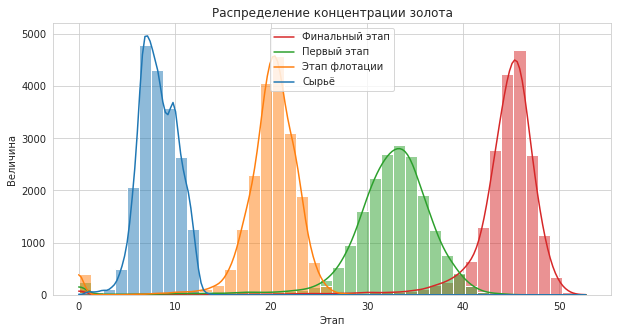

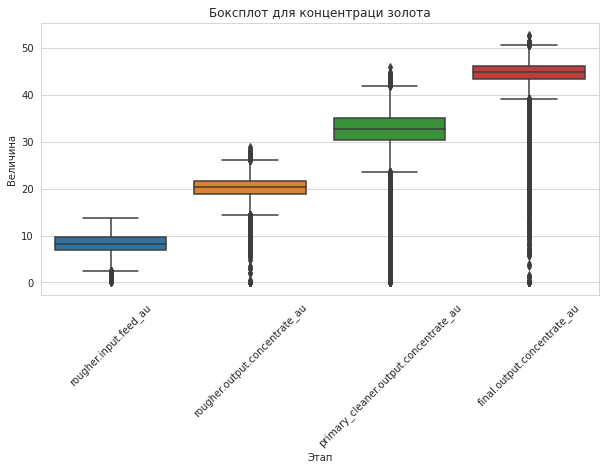

In [28]:
concentrate_graphs(concentrate_au)

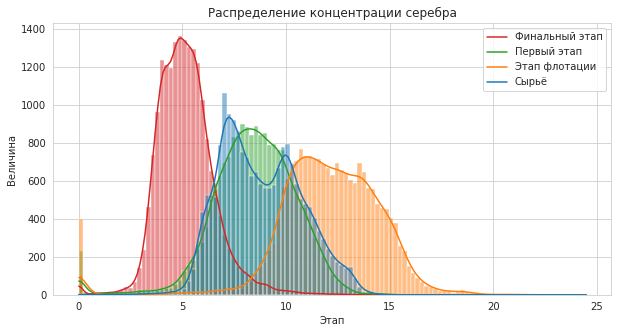

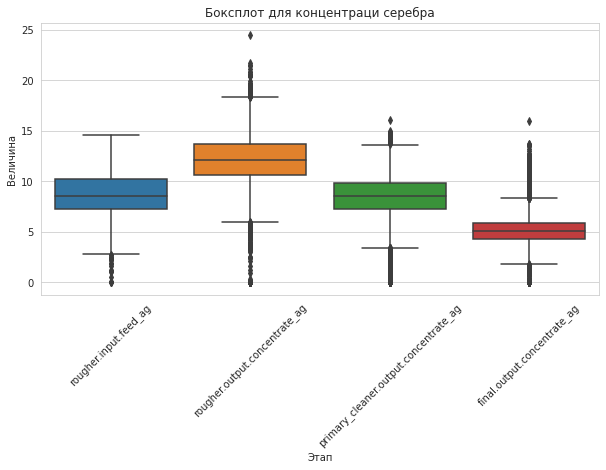

In [29]:
concentrate_graphs(concentrate_ag)

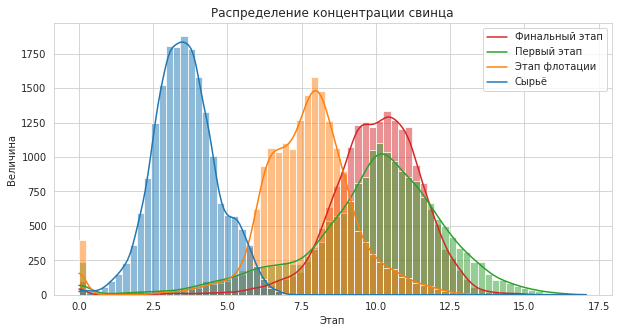

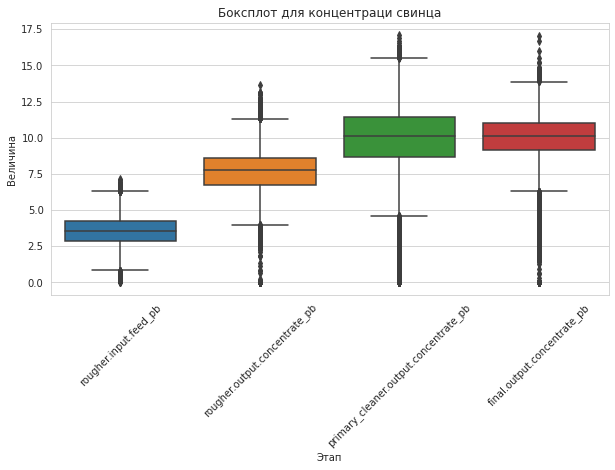

In [30]:
concentrate_graphs(concentrate_pb)

**Вывод**

- По графикам можно сделать вывод, что концентрация золота и серебра уменьшается в процессе обработки
- Концентрация свинца на этапе флотации и первом этапе очистки, примерно, одинаковая

In [31]:
columns_to_check = [
    ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'],
    ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag'],
    ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']
]

In [32]:
for column_set in columns_to_check:
    condition = df_full[column_set] >= 1  
    condition_row = condition.all(axis=1)  
    df_full_edited = df_full[condition_row] 

In [33]:
df_full_edited.shape

(18539, 86)

In [34]:
res_clean = (100 / df_full.shape[0]) * df_full_edited.shape[0]

print(f'Процент сохранённых данных в full: {res_clean}')

Процент сохранённых данных в full: 95.37013220844695


**Вывод**

Многочисленные нулевые значения в концентрации металлов – это явная аномалия, так как нет смысла добывать металлы там, где их нет, поэтому от этих значений мы избавились

Также удалим их из тестовой выборки

In [35]:
missing_indices = df_train.index.difference(df_full.index)
df_train = df_train.drop(missing_indices)
df_train.shape

(14579, 54)

**Сравним размеры гранул сырья**

Аналогично предыдущему заданию, найдём поля, в которых есть информация о размере

In [36]:
size = []

for i in df_train.columns:
    if 'size' in i:
        size.append(i)
        
# Мы получили столбцы с исходным сырьём и черновым концентратом, соответственно
size

['rougher.input.feed_size', 'primary_cleaner.input.feed_size']

In [37]:
r_size = pd.concat([df_train['rougher.input.feed_size'], df_test['rougher.input.feed_size']],
                   axis=1)
r_size.columns = ['train', 'test']

p_size = pd.concat([df_train['primary_cleaner.input.feed_size'], df_test['primary_cleaner.input.feed_size']],
                   axis=1)
p_size.columns = ['train', 'test']

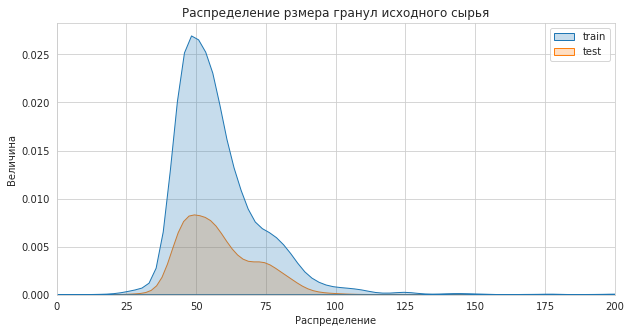

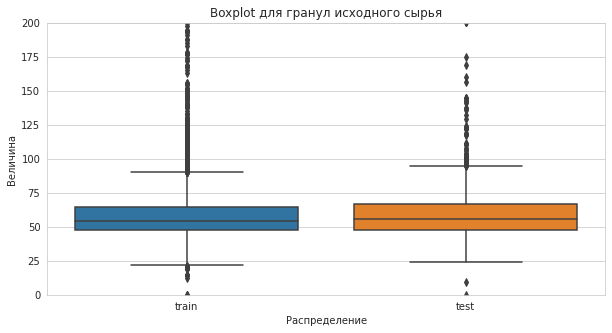

In [38]:
# это можно было бы тоже уместить в функцию, но удобней процедурно, в данном слчае

plt.figure(figsize=(10, 5))
sns.kdeplot(data=r_size, shade=True)
plt.title('Распределение рзмера гранул исходного сырья')
plt.xlim(0, 200) # Дальше 200 значение стабильно нулевое
plt.xlabel('Распределение')
plt.ylabel('Величина')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=r_size)
plt.title('Boxplot для гранул исходного сырья')
plt.ylim(0, 200) # Выбросы делают график нечитаемым
plt.xlabel('Распределение')
plt.ylabel('Величина')
plt.show()

**Вывод**

В целом, распределения не имеют особых различий, а значит, не повлияют на качество моделей. Более низкая "Вершина" у тестовой выборки обуславливается меньшим количеством значений

**Исследуем суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате**

Для этого в основном датасете нужно создать столбцы с суммами концентрации

In [39]:
r_input = ['rougher.input.feed_ag', 'rougher.input.feed_pb', 
           'rougher.input.feed_sol', 'rougher.input.feed_au']
r_output = ['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
            'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']
c_output = ['primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb',
            'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.concentrate_au']
f_output = ['final.output.concentrate_ag', 'final.output.concentrate_pb',
            'final.output.concentrate_sol', 'final.output.concentrate_au']

df_full['concentrate_feed'] = df_full[r_input].sum(axis=1) # Сырьё
df_full['concentrate_rougher'] = df_full[r_output].sum(axis=1) # Флотация
df_full['concentrate_primary'] = df_full[c_output].sum(axis=1) # Очистка
df_full['concentrate_final'] = df_full[f_output].sum(axis=1) # Финал

In [40]:
df_full.shape

(19439, 90)

In [41]:
df_full[['concentrate_feed', 
         'concentrate_rougher', 
         'concentrate_primary', 
         'concentrate_final']].isna().sum()

concentrate_feed       0
concentrate_rougher    0
concentrate_primary    0
concentrate_final      0
dtype: int64

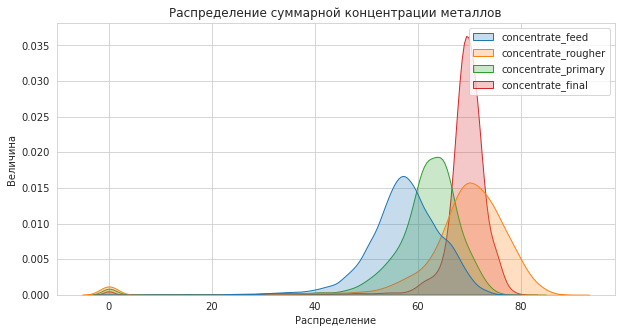

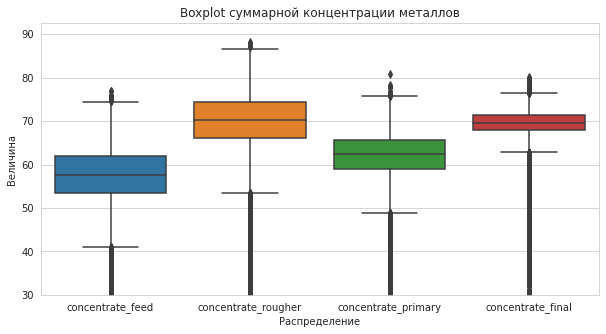

In [42]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df_full[['concentrate_feed', 
                     'concentrate_rougher', 
                     'concentrate_primary', 
                     'concentrate_final']],
                     shade=True)
plt.title('Распределение суммарной концентрации металлов')
plt.xlabel('Распределение')
plt.ylabel('Величина')
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_full[['concentrate_feed', 
                     'concentrate_rougher', 
                     'concentrate_primary', 
                     'concentrate_final']])
plt.title('Boxplot суммарной концентрации металлов')
plt.ylim(30)
plt.xlabel('Распределение')
plt.ylabel('Величина')
plt.show()

**Вывод**

- В процессе флотации концентрация металлов увеличивается, однако, во время очистки, вновь снижается, повышаясь в конце
- Все распределения смещены влево

- Есть незначительные скачки в районе нуля
- Нулевые значения – это, вероятно, выбросы, поэтому обрежем "хвост" с этими данными

In [43]:
print(df_full_edited.shape)
print(df_train.shape)
print(df_test.shape)

(18539, 86)
(14579, 54)
(4860, 54)


**Общиый вывод**

- Мы исследовали и предобработали данные об обработке металлов. Были заполнены пропуски и изменены поля для сохранения схожести в размерности разных датасетов
- Исследовали данные о концентрации различных металлов в процессе очистки и выяснили, что концентрация золота и серебра уменьшается в процессе обработки
- Оценили распределения данных на предмет вероятности негативного влияния на модель
- Проанализировали суммарную концентрацию металлов в процессе очистки: концентрация металлов увеличивается, однако, во время очистки, вновь снижается, повышаясь в конце


## Модель

**Функция sMAPE**

Для построения функции применим формулу

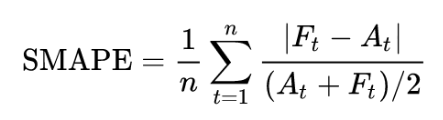

In [44]:
def sMAPE(y_valid, y_pred):
    res = 100 / len(y_valid) * np.sum(2 * np.abs(y_valid - y_pred) / (np.abs(y_valid) + np.abs(y_pred)))
    return res

In [45]:
def total_smape(r_score, f_score) -> float:
    return 0.25 * r_score + 0.75 * f_score

In [46]:
def data_separating(data):
    y_rougher = data['rougher.output.recovery']
    y_final = data['final.output.recovery']
    X = data.drop(['rougher.output.recovery', 'final.output.recovery'] , axis=1)
    return X, y_rougher, y_final

In [47]:
X_train, y_rougher_train, y_final_train = data_separating(df_train)
X_test, y_rougher_test, y_final_test = data_separating(df_test)

In [48]:
print(X_train.shape)
print(y_rougher_train.shape)
print(y_final_train.shape)

(14579, 52)
(14579,)
(14579,)


In [49]:
print(X_test.shape)
print(y_rougher_test.shape)
print(y_final_test.shape)

(4860, 52)
(4860,)
(4860,)


Для того, чтобы модель не отдавала предпочтения определённым признакам, проведём стандартизацию

In [50]:
numeric = list(X_train.columns)

scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

**Модель регрессии**

In [114]:
smape_scorer = make_scorer(sMAPE, greater_is_better=False)

In [142]:
%%time
# Для флотации
model_r_reg = LinearRegression()
model_r_reg.fit(X_train, y_rougher_train)
r_cv_score_reg = cross_val_score(model_r_reg, 
                                 X_train, 
                                 y_rougher_train, 
                                 cv=5, 
                                 scoring=smape_scorer)
r_reg_score = np.mean(r_cv_score_reg)

print(-r_reg_score)

13.781732828475333
CPU times: user 708 ms, sys: 767 ms, total: 1.48 s
Wall time: 1.35 s


In [141]:
%%time
# Для финального продукта
model_f_reg = LinearRegression()
model_f_reg.fit(X_train, y_final_train)
f_cv_score_reg = cross_val_score(model_f_reg, 
                                 X_train, 
                                 y_final_train, 
                                 cv=5, 
                                 scoring=smape_scorer)
f_reg_score = np.mean(f_cv_score_reg)

print(-f_reg_score)

11.169089731769134
CPU times: user 645 ms, sys: 859 ms, total: 1.5 s
Wall time: 1.43 s


Теперь рассчитаем итоговую оценку по формуле

**Итоговое sMAPE = 0.25 * sMAPE(rougher) * 0.75 sMAPE(final)**

In [144]:
total_regression_smape = total_smape(r_reg_score, f_reg_score)
-total_regression_smape

11.822250505945684

Если регрессия не особо "требовательна" к гиперпараметрам, то в дереве и лесе они имеют куда больший вес.
Для того, чтобы получить таблицы с наилушими значениями гиперпараметров и метриками, инициализируем класс OptimalModels, в котором будут 2 метода: для дерева решений и для случайного леса

In [123]:
class OptimalModels:
    @classmethod
    def decision_tree(cls,  X_train, y_train):
        res = pd.DataFrame(columns=['depth', 'score'])
        for i in range(1, 10):
            model = DecisionTreeRegressor(max_depth=i, random_state=42)
            model.fit(X_train, y_train)
            cross_validation = cross_val_score(model, 
                                               X_train, 
                                               y_train, 
                                               cv=5, 
                                               scoring=smape_scorer)
            score = np.mean(cross_validation)
            res = res.append({
                'depth': i,
                'score': score
            }, ignore_index=True)
        return res.sort_values(by='score', ascending=True).head(1)
    
    @classmethod
    def random_forest(cls,  X_train, y_train):
        res = pd.DataFrame(columns=['depth', 'estimators', 'score'])
        for i in range(2, 10):
            for j in range(2, 10):
                model = RandomForestRegressor(max_depth=i, n_estimators=j, random_state=42)
                model.fit(X_train, y_train)
                cross_validation = cross_val_score(model, 
                                                   X_train, 
                                                   y_train, 
                                                   cv=5, 
                                                   scoring=smape_scorer)
                score = np.mean(cross_validation)
                res = res.append({
                    'depth': i,
                    'estimators': j,
                    'score': score
                }, ignore_index=True)
        return res.sort_values(by='score', ascending=True).head(1)

In [124]:
%%time
best_for_tree_rougher = OptimalModels.decision_tree(X_train, 
                                                    y_rougher_train)

best_for_tree_final = OptimalModels.decision_tree(X_train, 
                                                  y_final_train)


best_for_tree_rougher

CPU times: user 33.8 s, sys: 12 ms, total: 33.8 s
Wall time: 33.8 s


,depth,score
8,9.0,-19.61528


In [125]:
%%time

best_for_tree_final

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


,depth,score
8,9.0,-16.654246


**Деревья решений**

Для флотации лучшая модель с глубиной 9, для финального продукта с глубиной 9 

In [145]:
r_tree_score = best_for_tree_rougher['score'].values
-r_tree_score

array([19.61527957])

In [146]:
f_tree_score = best_for_tree_final['score'].values
-f_tree_score

array([16.65424564])

In [147]:
total_tree_smape = total_smape(r_tree_score, f_tree_score)
-total_tree_smape

array([17.39450412])

**Выберем параметры для случайного леса**

In [129]:
%%time
best_for_forest_rougher = OptimalModels.random_forest(X_train, 
                                                      y_rougher_train)
best_for_forest_rougher

CPU times: user 7min 12s, sys: 176 ms, total: 7min 12s
Wall time: 7min 12s


,depth,estimators,score
57,9.0,3.0,-17.289664


In [131]:
%%time
best_for_forest_final = OptimalModels.random_forest(X_train,  
                                                    y_final_train)
best_for_forest_final

CPU times: user 7min 5s, sys: 204 ms, total: 7min 6s
Wall time: 7min 6s


,depth,estimators,score
48,8.0,2.0,-13.574556


**Случайный лес**

- Для флотации и финального: глубина 8, количество 2


In [148]:
r_forest_score = best_for_forest_rougher['score'].values
-r_forest_score

array([17.28966427])

In [149]:
f_forest_score = best_for_forest_final['score'].values
-f_forest_score

array([13.57455625])

In [150]:
total_forest_smape = total_smape(r_forest_score, f_forest_score)
-total_forest_smape

array([14.50333326])

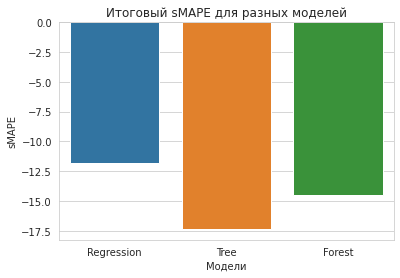

In [154]:
smape_values = [float(total_regression_smape), float(total_tree_smape), float(total_forest_smape)]
model_names = ["Regression", "Tree", "Forest"]

sns.barplot(x=model_names, y=smape_values)
plt.ylabel("sMAPE")
plt.xlabel("Модели")
plt.title("Итоговый sMAPE для разных моделей")
plt.show()

In [136]:
smape_values

[-11.822250505945684, -17.394504124962893, -14.503333257698912]

Поскольку мы измеряем не коэффициент детерминации, а количественную метрику, за лучшую модель мы принимаем с наиболее отрицательной метрикой, то есть, случайный лес (Я проверил другие модели, дерево показывает минимальную метрику)

**Тестирование модели**

Для начала создадим константную модель для того, чтобы обозначить планку, выше которой оценка быть не должна

In [137]:
# Константная модель

dummy_regr_r = DummyRegressor(strategy="mean")
dummy_regr_r.fit(X_train, y_rougher_train)
dummy_pred_r = dummy_regr_r.predict(X_test)
dummy_score_r = sMAPE(y_rougher_test, dummy_pred_r)

dummy_regr_f = DummyRegressor(strategy="mean")
dummy_regr_f.fit(X_train, y_final_train)
dummy_pred_f = dummy_regr_f.predict(X_test)
dummy_score_f = sMAPE(y_final_test, dummy_pred_f)

total_baseline_score = total_smape(dummy_score_r, dummy_score_f)

print(f'Baseline rougher: {dummy_score_r}')
print(f'Baseline final: {dummy_score_f}')
print(f'Baseline total: {total_baseline_score}')

Baseline rougher: 7.149670979818717
Baseline final: 9.407971043212594
Baseline total: 8.843396027364125


In [138]:
test_model_r_tree = DecisionTreeRegressor(max_depth=9,  
                                            random_state=42)
model_r_tree.fit(X_train, y_rougher_train)
y_pred = model_r_tree.predict(X_test)
smape_r = sMAPE(y_rougher_test, y_pred)
smape_r

6.773202159608633

In [139]:
test_model_f_tree = DecisionTreeRegressor(max_depth=9,  
                                            random_state=42)
model_f_tree.fit(X_train, y_final_train)
y_pred_f = model_f_tree.predict(X_test)
smape_f = sMAPE(y_final_test, y_pred_f)
smape_f

9.021213106920312

In [140]:
final_smape_score = total_smape(smape_r, smape_f)
final_smape_score

8.459210370092393

**Вывод**

**Оценка 8.45, что ниже, чем 8.84 у константной модели, значит, итоговая модель засчитывается**

Метрика на отдельно взятых моделях также ниже, чем у константной

- Были проанализированы 3 модели: линейная регрессия, дерево решений и случайный лес.
- Для поиска оптимальныхм параметров дерева и леса был написан класс OptimalModel
- Модели были обучены, были получены предсказания двух целевых признаков
- Качество предсказаний моделей было проверено на тестовых выборках с помощью метрики sMAPE
- К каждой модели построен график кросс-валидации

**Общий вывод**

- Были получены данные об обработке руды и получении металлов
- В данных были пропуски, которые были обработаны
- В тестовой выборке отсутствали ряд полей и целевые признаки. Чтобы решить эту проблему, недостающие поля у других датасетов были удалены, а в тестовую выборку добавлены целевые признаки
- Был проведёт разведовательный анализ даннах, в котором были определены концентрация металлов на разных этапах очистки, их суммарная концентрация, а также разница в распределении выборок, что могла повлиять на обучение модели
- Для приготовленных и исследованных данных были созданы 3 модели: линейная регрессия, дерево решений, случайный лес с подобранными гиперпараметрами.
- В качестве итоговой модели было выбрано дерево решений
- Модели были обучены, адекватность проверена на кросс-валидации
- Качество итоговой было проверено на тестовых выборках с помощью метрики sMAPE

**На основании полученной модели, мы получили ключевую метрику, равную 8.45%**